# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch cell line 1 to 8.   


In [252]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 16:35:25.080961
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [253]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [254]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [255]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [256]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=8
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 8 = NHEK


## Data Load

In [257]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [258]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 16:35:28.719950
Load RCI values...
Num RCI: 8738
Example RCI: [('ENSG00000000003', 0.460806), ('ENSG00000000419', 0.266253), ('ENSG00000000457', -0.778011)]
Load genes...
2022-12-29 16:35:28.748865
Load sequence...
2022-12-29 16:35:37.341693
Num IDs: 5161
Example IDs: [('ENSG00000157916', 'ENST00000605895.6'), ('ENSG00000007923', 'ENST00000377577.10'), ('ENSG00000120949', 'ENST00000417814.3'), ('ENSG00000055070', 'ENST00000401088.9')]
Count 1896 ones out of 5161 labels.
Example labels: [1, 0, 0, 1]
Num counts: 5161
Example sequence: [205, 49, 193, 4, 15, 58, 232, 160, 126, 248, 222, 117, 212, 78, 53, 211, 73, 34, 136, 30, 117, 209, 67, 11, 42, 166, 152, 95, 121, 227, 139, 44, 175, 185, 228, 143, 58, 232, 159, 121, 228, 143, 58, 232, 159, 124, 239, 186, 230, 152, 95, 121, 225, 132, 16, 62, 246, 213, 83, 74, 37, 147, 75, 43, 169, 163, 139, 41, 163, 139, 42, 165, 148, 79, 57, 227, 139, 44, 175, 186, 231, 156, 110, 182, 215, 89, 98, 136, 30, 118, 214, 88, 96, 126, 246, 214, 85, 

## Model

In [259]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [260]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 16:35:37.383549
COMPILE
Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_130 (Embedding)   (None, 3997, 4)           1028      
                                                                 
 conv1d_130 (Conv1D)         (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_11  (None, 64)               0         
 7 (GlobalAveragePooling1D)                                      
                                                                 
 dense_259 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [261]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 16:35:37.495770
2022-12-29 16:35:37.495933
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
Train sizes (4158, 3997) (4158, 1)
Valid sizes (1003, 3997) (1003, 1)
Train set ones/size 1516 / 4158
Valid set ones/size 380 / 1003
BUILD MODEL
COMPILE
FIT
2022-12-29 16:35:38.900527
Epoch 1/5
130/130 [==============================] - 2s 9ms/step - loss: 0.6509 - accuracy: 0.6344 - val_loss: 0.6425 - val_accuracy: 0.6211
Epoch 2/5
130/130 [==============================] - 1s 7ms/step - loss: 0.6240 - accuracy: 0.6506 - val_loss: 0.6018 - val_accuracy: 0.6750
Epoch 3/5
130/130 [==============================] - 1s 7ms/step - loss: 0.6152 - accuracy: 0.6671 - val_loss: 0.5955 - val_accuracy: 0.6650
Epoch 4/5
130/130 [==============================] - 1s 7ms/step - loss: 0.6114 - accuracy: 0.6688 - val_loss: 0.5914 - val_accuracy: 0.6680
Epoch 5/5
130/130 [==============================] - 1s 7ms/step - loss: 0.6073 - accuracy: 0.6712 - val_loss: 0.5883 - val_accuracy: 

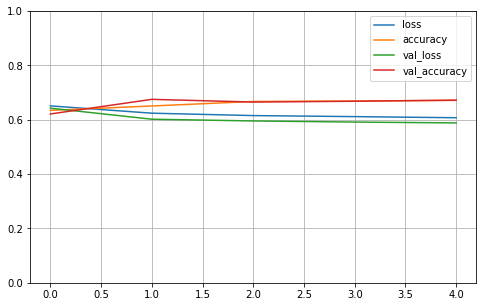

Compute valiation accuracy
2022-12-29 16:35:44.805428
Range of scores: 0.102473035 to 0.73288286
Predicted zeros and ones 834 169
Accuracy: 67.20% Precision: 65.09% Recall: 28.95% F1: 40.07%
2022-12-29 16:35:45.052856
Fold 2
Training example
[167 155 106 ...   0   0   0]
Train sizes (4090, 3997) (4090, 1)
Valid sizes (1071, 3997) (1071, 1)
Train set ones/size 1458 / 4090
Valid set ones/size 438 / 1071
BUILD MODEL
COMPILE
FIT
2022-12-29 16:35:46.328733
Epoch 1/5
128/128 [==============================] - 2s 9ms/step - loss: 0.6494 - accuracy: 0.6433 - val_loss: 0.6603 - val_accuracy: 0.5910
Epoch 2/5
128/128 [==============================] - 1s 7ms/step - loss: 0.6199 - accuracy: 0.6538 - val_loss: 0.6434 - val_accuracy: 0.6078
Epoch 3/5
128/128 [==============================] - 1s 7ms/step - loss: 0.6107 - accuracy: 0.6670 - val_loss: 0.6223 - val_accuracy: 0.6396
Epoch 4/5
128/128 [==============================] - 1s 8ms/step - loss: 0.6041 - accuracy: 0.6790 - val_loss: 0.6307 - v

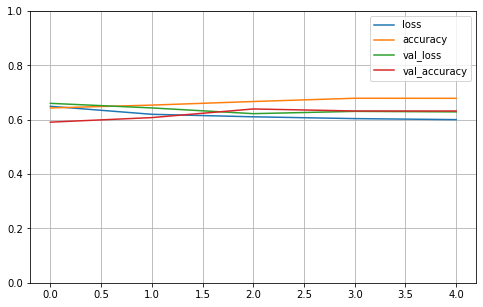

Compute valiation accuracy
2022-12-29 16:35:52.164006
Range of scores: 0.068740524 to 0.703552
Predicted zeros and ones 889 182
Accuracy: 63.21% Precision: 62.09% Recall: 25.80% F1: 36.45%
2022-12-29 16:35:52.381580
Fold 3
Training example
[167 155 106 ...   0   0   0]
Train sizes (4098, 3997) (4098, 1)
Valid sizes (1063, 3997) (1063, 1)
Train set ones/size 1480 / 4098
Valid set ones/size 416 / 1063
BUILD MODEL
COMPILE
FIT
2022-12-29 16:35:53.646198
Epoch 1/5
129/129 [==============================] - 2s 9ms/step - loss: 0.6467 - accuracy: 0.6388 - val_loss: 0.6624 - val_accuracy: 0.6077
Epoch 2/5
129/129 [==============================] - 1s 7ms/step - loss: 0.6050 - accuracy: 0.6647 - val_loss: 0.6679 - val_accuracy: 0.5983
Epoch 3/5
129/129 [==============================] - 1s 7ms/step - loss: 0.5965 - accuracy: 0.6747 - val_loss: 0.6714 - val_accuracy: 0.6087
Epoch 4/5
129/129 [==============================] - 1s 7ms/step - loss: 0.5947 - accuracy: 0.6818 - val_loss: 0.6685 - val

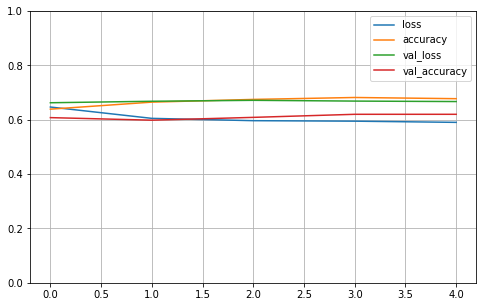

Compute valiation accuracy
2022-12-29 16:35:59.535079
Range of scores: 0.07197793 to 0.8074432
Predicted zeros and ones 807 256
Accuracy: 61.99% Precision: 52.34% Recall: 32.21% F1: 39.88%
2022-12-29 16:35:59.730934
Fold 4
Training example
[167 155 106 ...   0   0   0]
Train sizes (4091, 3997) (4091, 1)
Valid sizes (1070, 3997) (1070, 1)
Train set ones/size 1569 / 4091
Valid set ones/size 327 / 1070
BUILD MODEL
COMPILE
FIT
2022-12-29 16:36:00.962014
Epoch 1/5
128/128 [==============================] - 2s 9ms/step - loss: 0.6606 - accuracy: 0.6153 - val_loss: 0.5985 - val_accuracy: 0.6944
Epoch 2/5
128/128 [==============================] - 1s 7ms/step - loss: 0.6272 - accuracy: 0.6375 - val_loss: 0.5825 - val_accuracy: 0.7028
Epoch 3/5
128/128 [==============================] - 1s 8ms/step - loss: 0.6192 - accuracy: 0.6507 - val_loss: 0.5848 - val_accuracy: 0.7000
Epoch 4/5
128/128 [==============================] - 1s 7ms/step - loss: 0.6154 - accuracy: 0.6541 - val_loss: 0.6061 - val

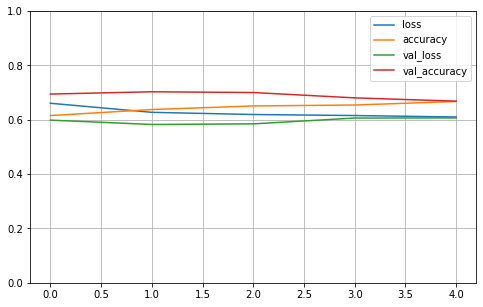

Compute valiation accuracy
2022-12-29 16:36:06.795846
Range of scores: 0.15901493 to 0.8061886
Predicted zeros and ones 668 402
Accuracy: 66.82% Precision: 46.52% Recall: 57.19% F1: 51.30%
2022-12-29 16:36:07.043054
Fold 5
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (4207, 3997) (4207, 1)
Valid sizes (954, 3997) (954, 1)
Train set ones/size 1561 / 4207
Valid set ones/size 335 / 954
BUILD MODEL
COMPILE
FIT
2022-12-29 16:36:08.285068
Epoch 1/5
132/132 [==============================] - 2s 9ms/step - loss: 0.6575 - accuracy: 0.6213 - val_loss: 0.6212 - val_accuracy: 0.6488
Epoch 2/5
132/132 [==============================] - 1s 7ms/step - loss: 0.6208 - accuracy: 0.6489 - val_loss: 0.6089 - val_accuracy: 0.6562
Epoch 3/5
132/132 [==============================] - 1s 8ms/step - loss: 0.6120 - accuracy: 0.6627 - val_loss: 0.5998 - val_accuracy: 0.6876
Epoch 4/5
132/132 [==============================] - 1s 7ms/step - loss: 0.6066 - accuracy: 0.6644 - val_loss: 0.5976 - val_ac

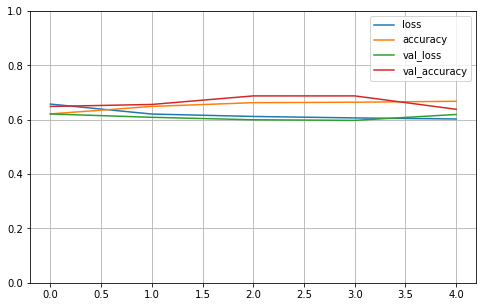

Compute valiation accuracy
2022-12-29 16:36:14.672359
Range of scores: 0.11414334 to 0.8442463
Predicted zeros and ones 578 376
Accuracy: 63.84% Precision: 48.67% Recall: 54.63% F1: 51.48%
2022-12-29 16:36:14.928394

Cross validation 5 folds 5 epochs
 accuracy mean 64.61% +/- 2.05
 precision mean 54.94% +/- 7.36
 recall mean 39.75% +/- 13.37
 F1 mean 43.84% +/- 6.30
2022-12-29 16:36:14.931271


In [262]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())